In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
import pandas as pd
import matplotlib.pyplot as plt
import re

# Análisis exploratorio de los datos, visualización y limpieza

In [3]:
train_data = pd.read_csv("./train.csv", index_col = 'id' )
test_data = pd.read_csv('./test.csv', index_col = 'id' )


# barajamos el dataset 
train_data = train_data.sample(frac=1, random_state=42)
test_data = test_data.sample(frac=1, random_state=42)

train_data.head(10)

,keyword,location,text,target
id,,,,
3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0
7934,rainstorm,NaN,@Calum5SOS you look like you got caught in a r...,0
2538,collision,NaN,my favorite lady came to our volunteer meeting...,1
2611,crashed,NaN,@brianroemmele UX fail of EMV - people want to...,1
9756,tragedy,"Los Angeles, CA",Can't find my ariana grande shirt this is a f...,0


### Tamaño de train según la etiqueta

Tamaño del conjunto de entrenamiento: (7613, 4)
Tamaño del conjunto de prueba: (3263, 3)


<Axes: xlabel='target'>

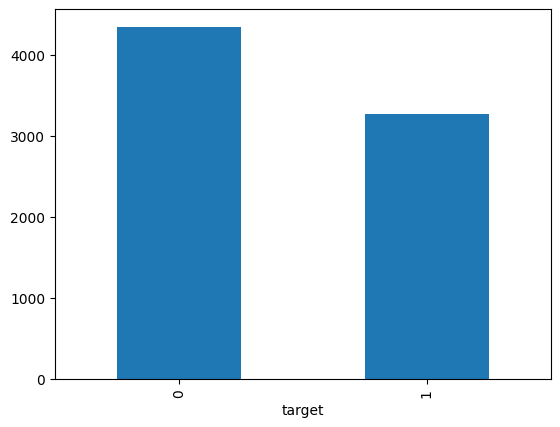

In [4]:
print(f'Tamaño del conjunto de entrenamiento: {train_data.shape}')
print(f'Tamaño del conjunto de prueba: {test_data.shape}')

train_data['target'].value_counts().plot(kind='bar')

### Número de palabras por tweet

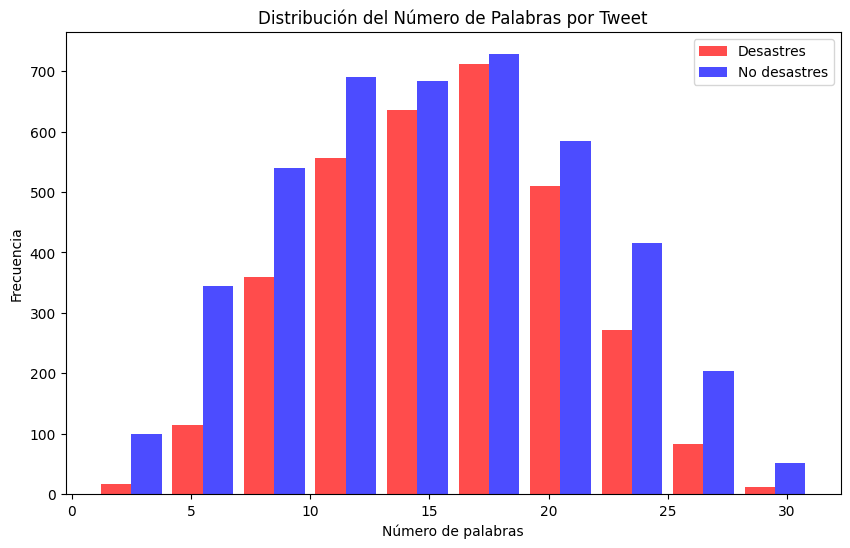

In [5]:
train_data['word_count'] = train_data['text'].apply(lambda x: len(x.split()))


plt.figure(figsize=(10, 6))
plt.hist([train_data[train_data['target'] == 1]['word_count'], 
          train_data[train_data['target'] == 0]['word_count']], 
          alpha=0.7, color=['red', 'blue'], label=['Desastres', 'No desastres'], rwidth=0.85)
plt.title('Distribución del Número de Palabras por Tweet')
plt.xlabel('Número de palabras')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()



In [ ]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

### Visualizamos las stopwords, urls y hashtags

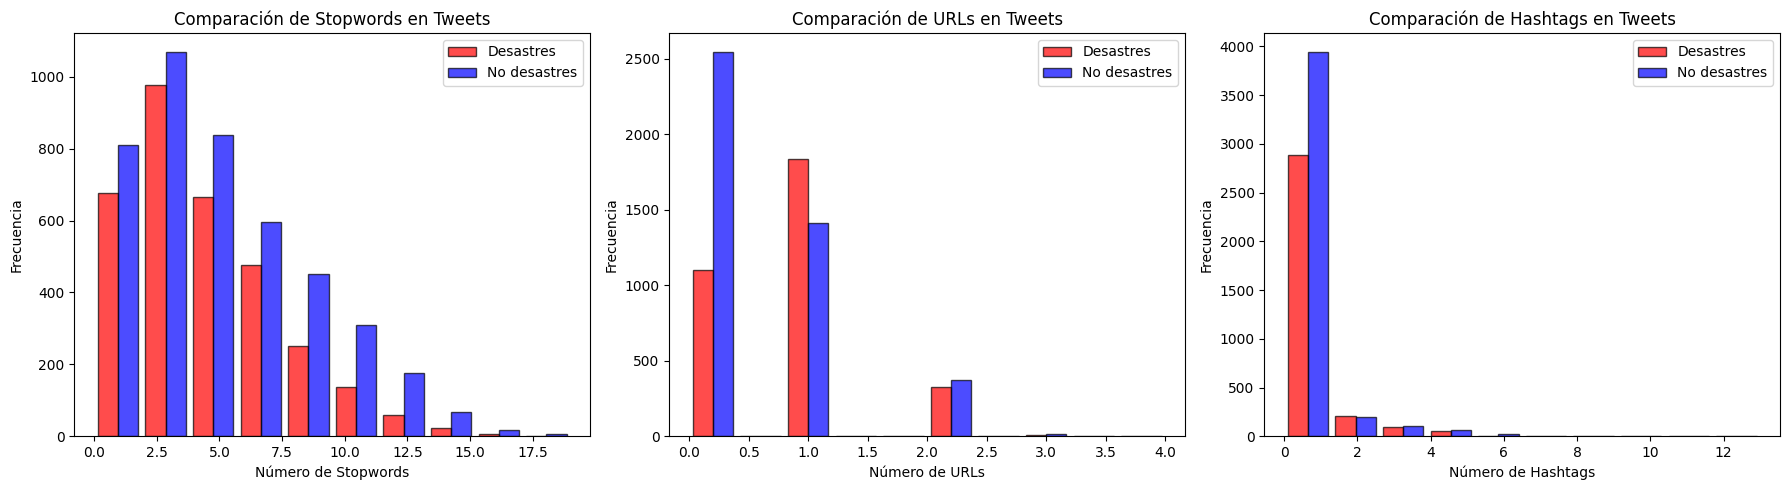

In [ ]:
stop_words = set(stopwords.words('english'))

# Reusando la función de conteo de stopwords
def count_stopwords(text):
    words = text.split()
    return sum(1 for word in words if word.lower() in stop_words)

# Reusando las funciones para contar URLs y Hashtags
def count_urls(text):
    return len(re.findall(r'http[s]?://\S+', text))

def count_hashtags(text):
    return len(re.findall(r'#(\w+)', text))

# Cuenta los datos
stopwords_desastres = train_data[train_data['target'] == 1]['text'].apply(count_stopwords)
stopwords_no_desastres = train_data[train_data['target'] == 0]['text'].apply(count_stopwords)

urls_count_desastres = train_data[train_data['target'] == 1]['text'].apply(count_urls)
urls_count_no_desastres = train_data[train_data['target'] == 0]['text'].apply(count_urls)

hashtags_count_desastres = train_data[train_data['target'] == 1]['text'].apply(count_hashtags)
hashtags_count_no_desastres = train_data[train_data['target'] == 0]['text'].apply(count_hashtags)

# Grafico
plt.figure(figsize=(18, 5))

# Gráfico de Stopwords
plt.subplot(1, 3, 1)
plt.hist([stopwords_desastres, stopwords_no_desastres], bins=10, color=['red', 'blue'], alpha=0.7, label=['Desastres', 'No desastres'], rwidth=0.85, edgecolor='black')
plt.title('Comparación de Stopwords en Tweets')
plt.xlabel('Número de Stopwords')
plt.ylabel('Frecuencia')
plt.legend()

# Gráfico de URLs
plt.subplot(1, 3, 2)
plt.hist([urls_count_desastres, urls_count_no_desastres], bins=10, color=['red', 'blue'], alpha=0.7, label=['Desastres', 'No desastres'], rwidth=0.85, edgecolor='black')
plt.title('Comparación de URLs en Tweets')
plt.xlabel('Número de URLs')
plt.ylabel('Frecuencia')
plt.legend()

# Gráfico de Hashtags
plt.subplot(1, 3, 3) 
plt.hist([hashtags_count_desastres, hashtags_count_no_desastres], bins=10, color=['red', 'blue'], alpha=0.7, label=['Desastres', 'No desastres'], rwidth=0.85, edgecolor='black')
plt.title('Comparación de Hashtags en Tweets')
plt.xlabel('Número de Hashtags')
plt.ylabel('Frecuencia')
plt.legend()

plt.tight_layout()
plt.show()


Guardamos los stopwords, urls y hashtags en el train por si nos fuese util en el futuro

In [ ]:
train_data['stopwords'] = train_data['text'].apply(count_stopwords)
train_data['urls_count'] = train_data['text'].apply(count_urls)
train_data['hashtags_count'] = train_data['text'].apply(count_hashtags)

train_data.head()

,keyword,location,text,target,word_count,stopwords,urls_count,hashtags_count
id,,,,,,,,
3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1,11,6,0,0
3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0,21,9,0,1
7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1,15,3,1,0
191,aftershock,NaN,Aftershock back to school kick off was great. ...,0,21,9,0,0
9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0,17,5,0,0


### N-gramas sin la limpieza de datos

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Ejemplo de un CountVectorizer para bigramas
vectorizer = CountVectorizer(ngram_range=(2, 2))
X2 = vectorizer.fit_transform(train_data['text'])

# Visualización de los bigramas más comunes
bigrams = pd.DataFrame(X2.sum(axis=0), columns=vectorizer.get_feature_names_out(), index=['count']).transpose()
bigrams.nlargest(10, 'count')


,count
http co,4306
https co,410
in the,308
of the,256
û_ http,217
on the,129
to the,126
to be,108
for the,97
at the,85


### Definimos y aplicamos la limpieza a los datos
Para ello vamos a remover las URLs, HTML, stopwords, signos de puntuación y emoticonos

In [ ]:
import re
from html.parser import HTMLParser

# Crear una instancia de HTMLParser
html_parser = HTMLParser()

# Función para eliminar URLs
def remove_urls(text):
    return re.sub(r'http[s]?://\S+', '', text)


# Función actualizada para eliminar HTML sin usar unescape
def remove_html(text):
    return re.sub(r'<.*?>', '', text)  # Esto elimina etiquetas HTML

# Función para eliminar stopwords
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# Función para eliminar signos de puntuación
def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)

# Función para eliminar emoticonos
def remove_emoticons(text):
    emoticon_pattern = re.compile(u'['
        u'\U0001F600-\U0001F64F'
        u'\U0001F300-\U0001F5FF' 
        u'\U0001F680-\U0001F6FF'
        u'\U0001F700-\U0001F77F' 
        u'\U0001F780-\U0001F7FF' 
        u'\U0001F800-\U0001F8FF' 
        u'\U0001F900-\U0001F9FF' 
        u'\U0001FA00-\U0001FA6F'  
        u'\U0001FA70-\U0001FAFF'  
        u'\U00002702-\U000027B0'  
        u'\U000024C2-\U0001F251' 
        u'\U0001F910-\U0001F9FF'
        ']+', flags=re.UNICODE)
    return emoticon_pattern.sub(r'', text)

def clean_text(text):
    text = remove_urls(text)
    text = remove_html(text)
    text = remove_stopwords(text)
    text = remove_punctuation(text)
    text = remove_emoticons(text)
    return text

# Aplicar la función de limpieza general a los conjuntos de datos de train y test
train_data['text_cleaned'] = train_data['text'].apply(clean_text)
test_data['text_cleaned'] = test_data['text'].apply(clean_text)

train_data.head(10)

,keyword,location,text,target,word_count,stopwords,urls_count,hashtags_count,text_cleaned
id,,,,,,,,,
3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1,11,6,0,0,new weapon cause unimaginable destruction
3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0,21,9,0,1,famping things GISHWHES got soaked deluge goin...
7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1,15,3,1,0,DT georgegalloway RT Galloway4Mayor ÛÏThe CoL ...
191,aftershock,NaN,Aftershock back to school kick off was great. ...,0,21,9,0,0,Aftershock back school kick great want thank e...
9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0,17,5,0,0,response trauma Children Addicts develop defen...
7934,rainstorm,NaN,@Calum5SOS you look like you got caught in a r...,0,19,10,0,0,Calum5SOS look like got caught rainstorm amazi...
2538,collision,NaN,my favorite lady came to our volunteer meeting...,1,18,7,1,0,favorite lady came volunteer meeting hopefully...
2611,crashed,NaN,@brianroemmele UX fail of EMV - people want to...,1,27,7,0,0,brianroemmele UX fail EMV people want insert ...
9756,tragedy,"Los Angeles, CA",Can't find my ariana grande shirt this is a f...,0,11,4,0,0,Cant find ariana grande shirt fucking tragedy


### N-gramas tras la limpieza

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Ejemplo de un CountVectorizer para bigramas
vectorizer = CountVectorizer(ngram_range=(2, 2))
X2 = vectorizer.fit_transform(train_data['text_cleaned'])

# Visualización de los bigramas más comunes
bigrams = pd.DataFrame(X2.sum(axis=0), columns=vectorizer.get_feature_names_out(), index=['count']).transpose()
bigrams.nlargest(10, 'count')

,count
suicide bomber,59
burning buildings,58
youtube video,43
liked youtube,42
northern california,41
cross body,39
oil spill,39
california wildfire,34
suicide bombing,34
looks like,33


### Vectorización TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)  # Limitar el número de features para evitar sobreajustes y reducir la complejidad

# Vectorización del conjunto de entrenamiento
X_train = vectorizer.fit_transform(train_data['text_cleaned'])

# Vectorización del conjunto de prueba usando solo transform
X_test = vectorizer.transform(test_data['text_cleaned'])

# Obtener las etiquetas del conjunto de entrenamiento
y_train = train_data['target']


### División de train y val

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)  # 10% para validación

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)


Training set shape: (6851, 5000)
Validation set shape: (762, 5000)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras_tuner.tuners import Hyperband 

def build_model(hp):
    model = Sequential()
    
    # Input layer
    model.add(Dense(units=hp.Int('units_input', min_value=16, max_value=128, step=32),
                    activation=hp.Choice('activation', values=['relu', 'tanh']),
                    input_dim=X_train.shape[1]))
    
    # Tune de las hidden layers
    for i in range(hp.Int('num_layers', min_value=1, max_value=2)):  # Between 1 and 5 hidden layers
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=16, max_value=128, step=32),
                        activation=hp.Choice('activation', values=['relu', 'tanh'])))
        model.add(Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.5, step=0.2)))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Tune del learning rate
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')

    model.compile(optimizer=Adam(learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=30,
    factor=3,
    directory='my_dir',
    project_name='twitter_tunning2'
)


Reloading Tuner from my_dir\twitter_tunning2\tuner0.json


In [ ]:
tuner.search(X_train, y_train, epochs=30, validation_data=(X_val, y_val))

### Entrenamiento del mejor modelo

In [ ]:
import matplotlib.pyplot as plt

# Obtiene el mejor modelo
best_models = tuner.get_best_models(num_models=3)
best_model = best_models[0]

history = best_model.fit(
    X_train, y_train,
    epochs=20,  
    validation_data=(X_val, y_val),
    batch_size=512,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)]
)


Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8813 - loss: 0.3021 - val_accuracy: 0.7966 - val_loss: 0.5240
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9134 - loss: 0.2332 - val_accuracy: 0.7887 - val_loss: 0.5813
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9287 - loss: 0.1900 - val_accuracy: 0.7900 - val_loss: 0.7189
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9475 - loss: 0.1381 - val_accuracy: 0.7822 - val_loss: 0.8445
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9586 - loss: 0.1099 - val_accuracy: 0.7690 - val_loss: 1.0041
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9693 - loss: 0.0796 - val_accuracy: 0.7690 - val_loss: 1.1640
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9738 - loss: 0.0634 - val_accuracy: 0.7703 - val_loss: 1.2965
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9755 - loss: 0.0570 - val_accuracy: 0.7690 - val_loss

### Evaluación y visualización del modelo

In [ ]:
# Evaluar el modelo en el conjunto de validación
loss, accuracy = best_model.evaluate(X_val, y_val)
print("Validation Accuracy: {:.2f}".format(accuracy))


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7817 - loss: 0.5597 
Validation Accuracy: 0.80


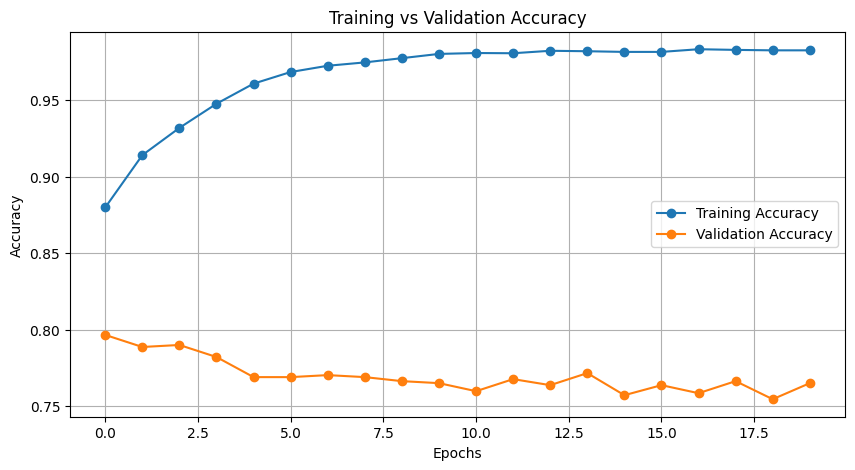

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(10, 5))
plt.plot(acc, label='Training Accuracy', marker='o')
plt.plot(val_acc, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


### Predicciones para el test data:

In [ ]:
import numpy as np

# Genera las predicciones
test_predictions = best_model.predict(X_test)

test_predictions_binary = (test_predictions > 0.5).astype(int)

num_samples = 10 
np.random.seed(128)
sample_indices = np.random.choice(len(test_data), num_samples, replace=False)

# Las muestra
for idx in sample_indices:
    print(f"Tweet: {test_data.iloc[idx]['text']}")
    print(f"Tweet limpio: {test_data.iloc[idx]['text_cleaned']}")
    print(f"Label: {'Desastre' if test_predictions_binary[idx] == 1 else 'No es un desastre'}")
    print("-" * 100)


102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step
Tweet: #GRupdates Pic of 16yr old PKK suicide bomber who detonated bomb in Turkey Army trench released --&gt;... http://t.co/P5yASKTq0K
Tweet limpio: GRupdates Pic 16yr old PKK suicide bomber detonated bomb Turkey Army trench released gt
Label: Desastre
----------------------------------------------------------------------------------------------------
Tweet: 02 03 04 05 AVALANCHE 1500 REAR AXLE ASSEMBLY 2055271 http://t.co/VxZhZsAlra http://t.co/HmXWRkbLS0
Tweet limpio: 02 03 04 05 AVALANCHE 1500 REAR AXLE ASSEMBLY 2055271
Label: No es un desastre
----------------------------------------------------------------------------------------------------
Tweet: 11000 SEEDS 30 VEGETABLE FRUIT VARIETY GARDEN KIT EMERGENCY SURVIVAL GEAR MRE  - Full reaÛ_ http://t.co/OH4YSttyCo http://t.co/X8Kv8tZZE8
Tweet limpio: 11000 SEEDS 30 VEGETABLE FRUIT VARIETY GARDEN KIT EMERGENCY SURVIVAL GEAR MRE  Full reaÛ_
Label: No es un desastre
--------------------------